In [92]:
import numpy as np
import pandas as pd
import sys
import sys
import os
sys.path.append('../')
os.getcwd()
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [3]:
import src
import src.recommendation
reload(src.recommendation)
from src.recommendation import *

# Plot Trajectories with Pictures

- take dimension (e.g. red) that I've trained the nn features to classify and plot sequences in that dimension. 
- use sequences that have images

In [102]:
# our lib
from lib.resnet50 import ResNet50
from lib.imagenet_utils import preprocess_input, decode_predictions

#keras 
from keras.preprocessing import image
from keras.models import Model

import glob

def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return(x,img)

In [100]:
# instantiate the model
base_model = ResNet50(include_top=False, weights='imagenet') #this will pull the weights from the folder 

# cut the model to lower levels only 
model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)

../lib/resnet50.py:165: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), strides=(2, 2), name="conv1")`
  x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
../lib/resnet50.py:90: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), strides=(1, 1), name="res2a_branch2a")`
  name=conv_name_base + '2a')(input_tensor)
../lib/resnet50.py:95: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", name="res2a_branch2b")`
  name=conv_name_base + '2b')(x)
../lib/resnet50.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c")`
  x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
../lib/resnet50.py:103: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), strides=(1, 1), name="res2a_branch1")`
  name=conv_name_base + '1')(input_tensor)
../lib/resnet50.py:106: UserWarning: The `merge` function 

limit_output extension: Maximum message size of 10000 exceeded with 10692 characters

In [110]:
user_id = 106144465 

#get images 
folder = '../data_img_sample_item_view_sequences/'
img_files = glob.glob(folder+'*'+str(user_id)+'*')
print(img_files)


# make features 
trajectory_features = np.empty((len(img_files),2048))
for i,img_file in enumerate(img_files):
    x,img = preprocess_img(img_file) # preprocess
    trajectory_features[i,:] = model.predict(x)[0,0,0,:]
    

['../data_img_sample_item_view_sequences/106144465_1_82548633538732181_0_view_.jpg', '../data_img_sample_item_view_sequences/106144465_2_310261911240101889_11_view_.jpg', '../data_img_sample_item_view_sequences/106144465_3_75793218577661959_2_view_.jpg', '../data_img_sample_item_view_sequences/106144465_4_76074708321099781_5_view_.jpg', '../data_img_sample_item_view_sequences/106144465_5_98029795868614676_4_view_.jpg', '../data_img_sample_item_view_sequences/106144465_6_22313013691846692_3_view_.jpg', '../data_img_sample_item_view_sequences/106144465_7_467887899726037038_4_view_.jpg', '../data_img_sample_item_view_sequences/106144465_8_216812239953170449_21_buy_.jpg']


In [111]:
red_traj = np.dot(trajectory_features,red_weights)

target class
here


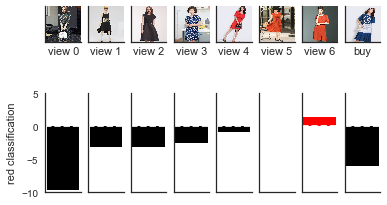

In [145]:
print('target class')
plt.figure(figsize=(12,6))
len_seq = len(img_files)

fig,axes = plt.subplots(2,len_seq)

# make color
color_red_black = pd.Series(red_traj>0).map({False:'k',True:'r'}).as_matrix()

for i in range(len_seq):
    img = image.load_img(img_files[i], target_size=(224, 224))

    # images
    axes[0,i].imshow(img)
    axes[0,i].set_xticklabels([])
    #axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_xaxis().set_ticks([])
    axes[0,i].get_yaxis().set_visible(False) 
    if i<(len_seq-1):
        axes[0,i].set_xlabel('view '+str(i))
    else:
        axes[0,i].set_xlabel('buy')
         
    # bar 
    axes[1,i].bar(0,red_traj[i],color=color_red_black[i])
    axes[1,i].set_ylim([-10,5])
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].axhline(y=0,linestyle='--',color='w')
    if i==0:
        print('here')
        axes[1,i].set_ylabel('red classification')
    else:
        axes[1,i].get_yaxis().set_visible(False) 
    sns.despine()
savefile = '../figures/example_sequence_interpretable_features_ui_'+str(user_id)+'.png'
plt.savefig(savefile,dpi=300)

In [152]:
reload(src.s3_data_management)
from src import s3_data_management
s3_data_management.push_results_to_s3(os.path.basename(savefile),savefile)

.........
https://s3-us-west-2.amazonaws.com/bishopbucket/proj_cdips/Results/example_sequence_interpretable_features_ui_106144465.png


# Plot Trajectories from User Profile Eval Dataset

- same as above, but without images. 

In [4]:
# load weights from the nn
red_weights = np.loadtxt('../data_nn_features/class_weights_LR_redpink.txt')

In [7]:
# load smaller user behavior dataset
user_profile = pd.read_pickle('../data_user_view_buy/user_profile_items_nonnull_features_20_mins_5_views_v2_sample1000.pkl')
user_sample = user_profile.user_id.unique()
print(len(user_profile))
print(len(user_sample))
user_profile.head()

40141
961


,user_id,buy_spu,buy_sn,buy_ct3,view_spu,view_sn,view_ct3,time_interval,view_cnt,view_seconds,index,spu_id,view_spu_count,drop
1226,3787002243,14994645517246498,10006541,334,221597279072104476,10005949,334,389705,4,98,87616.0,2.215973e+17,11,0
1227,3787002243,14994645517246498,10006541,334,29349802448457744,10004542,334,7342,1,10,73880.0,2.934980e+16,11,0
2261,132681117,6831894477217820,10001155,334,27661017974767638,10004048,334,32451,1,6,21676.0,2.766102e+16,63,0
2262,132681117,6831894477217820,10001155,334,288869796837830741,10000351,334,33318,2,30,6475.0,2.888698e+17,63,0
2263,132681117,6831894477217820,10001155,334,301817675098247170,10020640,334,428149,1,9,25612.0,3.018177e+17,63,0


In [6]:
# read nn features 
spu_fea = pd.read_pickle("../data_nn_features/spu_fea_sample1000.pkl")



In [53]:
spu_fea.head()

,index,spu_id,features,view_spu
2,4,100281553839460375,"[0.661, 1.84, 0.028, 1.128, 0.172, 1.097, 1.45...",100281553839460375
10,17,102533309850574975,"[0.351, 0.066, 0.044, 0.648, 0.011, 0.0, 0.207...",102533309850574975
11,18,102533356906119172,"[0.474, 0.903, 0.03, 0.495, 0.01, 0.003, 0.2, ...",102533356906119172
16,26,1029993181497487363,"[0.029, 0.347, 0.175, 0.789, 0.09, 0.0, 0.181,...",1029993181497487363
17,27,103096330169212941,"[1.117, 0.826, 0.01, 0.058, 0.251, 0.783, 0.12...",103096330169212941


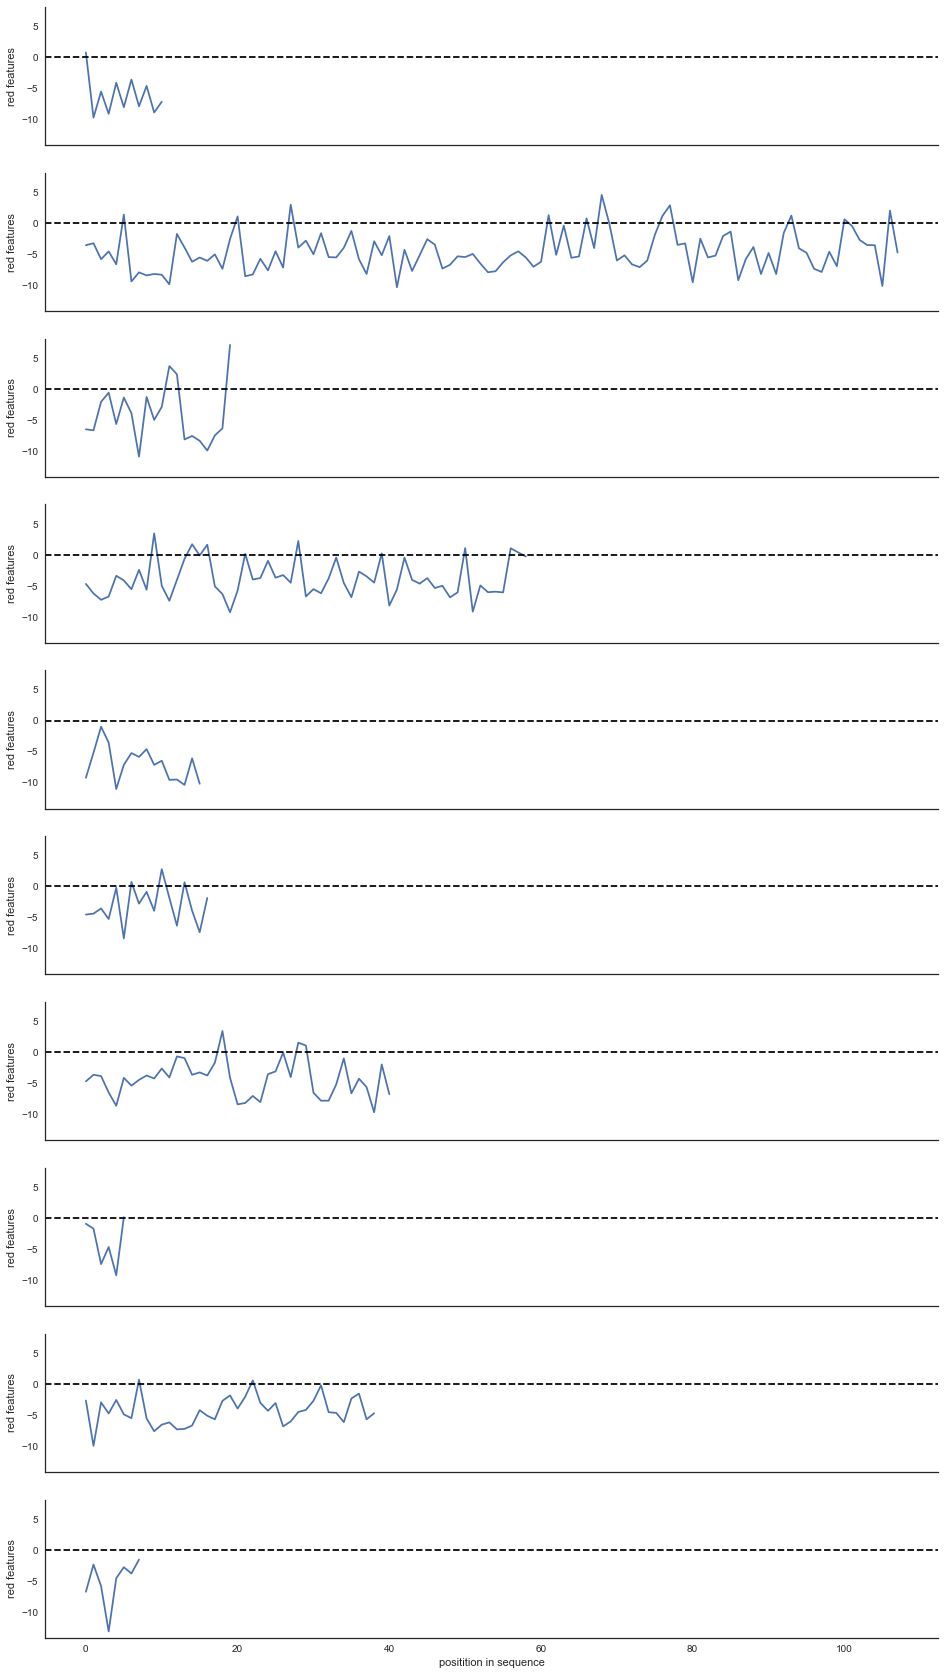

In [32]:
# sample users
size = 10
np.random.seed(1000)
user_ids = np.random.choice(user_profile.user_id.unique(),size=size)


fig,axes = plt.subplots(size,1,figsize=(16,3*size),sharex=True,sharey=True)

for ui,user_id in enumerate(user_ids):
    # get his trajectory
    trajectory = user_profile.loc[user_profile.user_id==user_id,]
    
    # get trajectory features (make a separate function # )
    trajectory_features = np.empty((len(trajectory),2048))
    for i,(index,row) in enumerate(trajectory.iterrows()):
        trajectory_features[i,:] = spu_fea.loc[spu_fea.spu_id==row['view_spu'],'features'].as_matrix()[0]
        
    # project onto red dimension
    red_traj = np.dot(trajectory_features,red_weights)

    # plot 
    axes[ui].plot(np.arange(len(red_traj)),red_traj)
    axes[ui].axhline(y=0,linestyle='--',color='k')
    axes[ui].set_ylabel('red features')
    sns.despine()
plt.xlabel('positition in sequence')
savefile = '../figures/example_sequences_red_10_users.png'
plt.savefig(savefile,dpi=300)

In [35]:
from sklearn.decomposition import PCA

In [54]:
trajectory.head()

40141
961


,user_id,buy_spu,buy_sn,buy_ct3,view_spu,view_sn,view_ct3,time_interval,view_cnt,view_seconds,index,spu_id,view_spu_count,drop
1226,3787002243,14994645517246498,10006541,334,221597279072104476,10005949,334,389705,4,98,87616.0,2.215973e+17,11,0
1227,3787002243,14994645517246498,10006541,334,29349802448457744,10004542,334,7342,1,10,73880.0,2.934980e+16,11,0
2261,132681117,6831894477217820,10001155,334,27661017974767638,10004048,334,32451,1,6,21676.0,2.766102e+16,63,0
2262,132681117,6831894477217820,10001155,334,288869796837830741,10000351,334,33318,2,30,6475.0,2.888698e+17,63,0
2263,132681117,6831894477217820,10001155,334,301817675098247170,10020640,334,428149,1,9,25612.0,3.018177e+17,63,0


In [50]:
#spu_fea.spu_id['spu_']

In [68]:
# read nn features 
spu_fea = pd.read_pickle("../data_nn_features/spu_fea_sample1000.pkl")


In [84]:
# reduce dimensionality 
pca = pickle.load(open('../data_nn_features/pca_all_items_sample1000.pkl','rb'))

In [93]:
plt.plot(red_traj,np.arange(len(red_traj)))
plt.xlabel('red features')
plt.ylabel('positition in sequence')
sns.despine()

(1000, 2048)

In [76]:
len(spu_fea['features'].as_matrix()[0])

2048

In [43]:
#spu_fea[row['view_spu']]

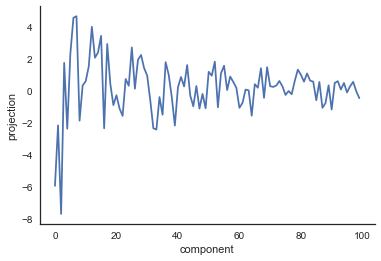

In [78]:
projection = pca.transform(X_item_feature[0,:].reshape(-1,1).T)
projection.shape
plt.plot(np.arange(100),projection[0,0:100])
plt.xlabel('component')
plt.ylabel('projection')
sns.despine()

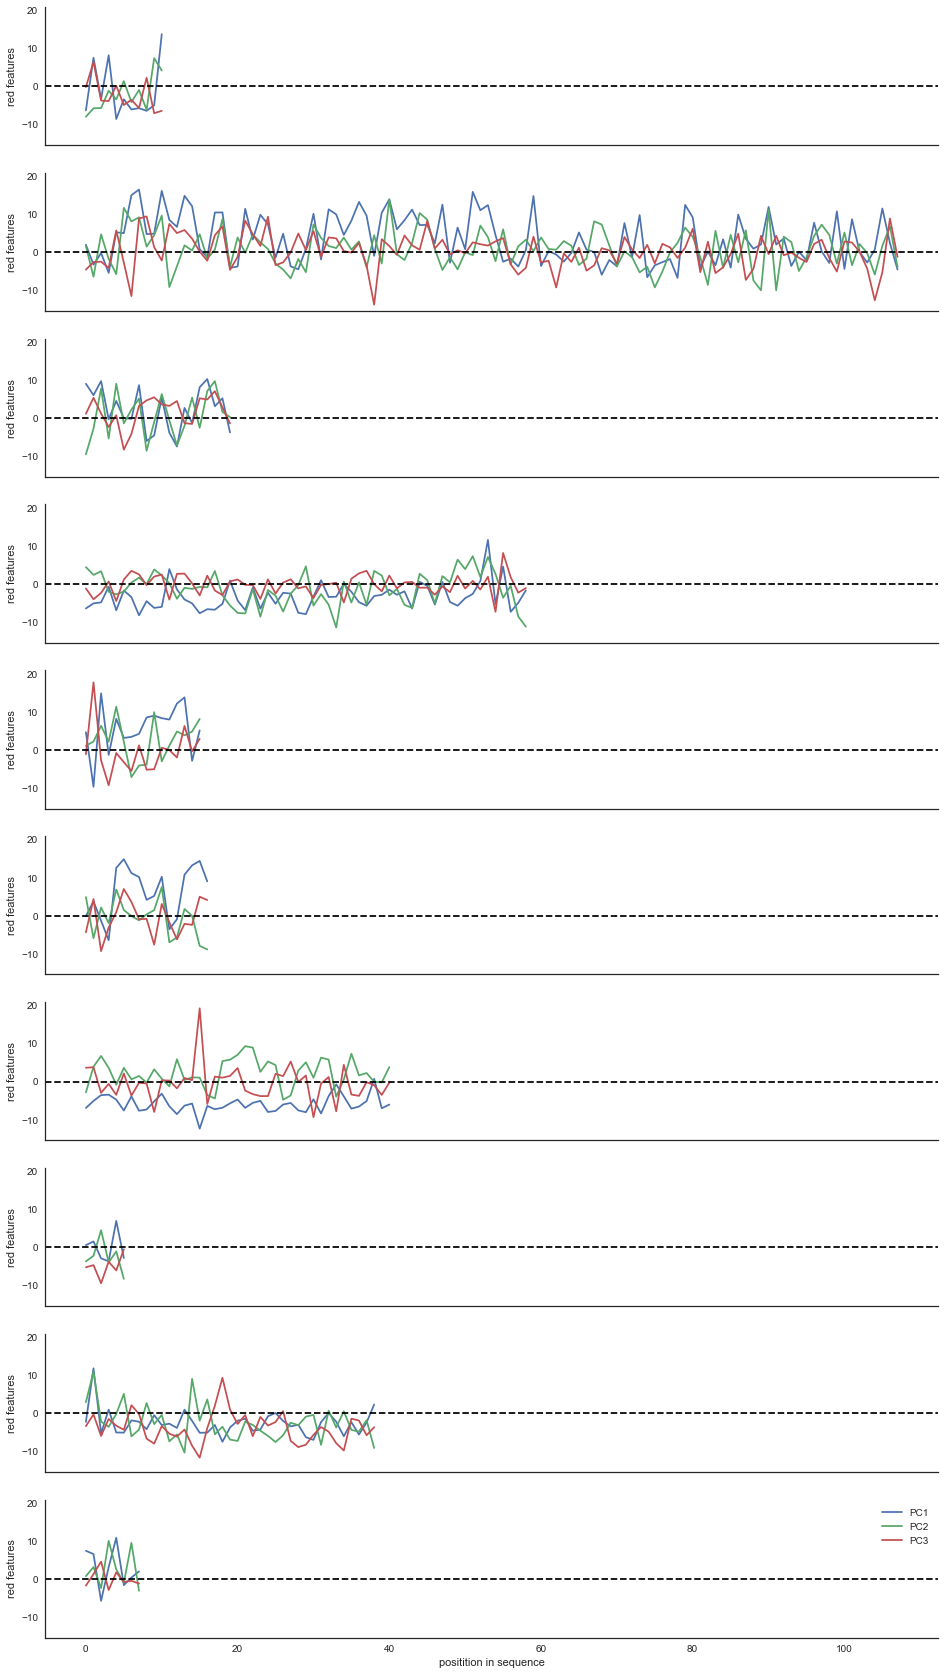

In [81]:
# sample users
size = 10
np.random.seed(1000)
user_ids = np.random.choice(user_profile.user_id.unique(),size=size)


fig,axes = plt.subplots(size,1,figsize=(16,3*size),sharex=True,sharey=True)

for ui,user_id in enumerate(user_ids):
    # get his trajectory
    trajectory = user_profile.loc[user_profile.user_id==user_id,]
    
    # get trajectory features (make a separate function # )
    trajectory_features = np.empty((len(trajectory),2048))
    for i,(index,row) in enumerate(trajectory.iterrows()):
        trajectory_features[i,:] = spu_fea.loc[spu_fea.spu_id==row['view_spu'],'features'].as_matrix()[0]
        
    # project onto pca dimension
    projected_traj = pca.transform(trajectory_features)
    
    # get first dimension 
    traj_PC1 = projected_traj[:,0]
    traj_PC2 = projected_traj[:,1]
    traj_PC3 = projected_traj[:,2]

    # plot 
    axes[ui].plot(traj_PC1,label='PC1')
    axes[ui].plot(traj_PC2,label='PC2')
    axes[ui].plot(traj_PC3,label='PC3')
    
    plt.legend()
    
    axes[ui].axhline(y=0,linestyle='--',color='k')
    axes[ui].set_ylabel('red features')
    sns.despine()
plt.xlabel('positition in sequence')
savefile = '../figures/example_sequences_PCA_10_users.png'
plt.savefig(savefile,dpi=300)

# Save 

In [153]:
%%bash 
#jupyter nbconvert --to Plotting_Sequences_in_low_dimensions.ipynb && mv Plotting_Sequences_in_low_dimensions.slides.html ../notebook_slides/Plotting_Sequences_in_low_dimensions_v1.slides.html
jupyter nbconvert --to html Plotting_Sequences_in_low_dimensions.ipynb && mv Exploring_Data.html ../notebook_htmls/Plotting_Sequences_in_low_dimensions_v1.html
cp Plotting_Sequences_in_low_dimensions.ipynb ../notebook_versions/Plotting_Sequences_in_low_dimensions_v1.ipynb

[NbConvertApp] Converting notebook Plotting_Sequences_in_low_dimensions.ipynb to html
[NbConvertApp] Writing 357480 bytes to Plotting_Sequences_in_low_dimensions.html
mv: rename Exploring_Data.html to ../notebook_htmls/Plotting_Sequences_in_low_dimensions_v1.html: No such file or directory
